In [187]:
%pip install pandas
%pip install html
%pip install seaborn
%pip install scikit-surprise

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
  Using cached html-1.16.tar.gz (7.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [6 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-install-3ng53mcj/html_8606ad4fb4674a50868173a8979ff03f/setup.py", line 12, in <module>
          long_description = __doc__.decode('utf8'),
      AttributeError: 'str' object has no attribute 'decode'. Did you mean: 'encode'?
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

× Encountered

In [2]:
import pandas as pd
import numpy as np
import surprise

In [3]:
# https://stackoverflow.com/questions/40399640/reading-csv-files-with-python-pandas-when-there-is-html-escaped-string-in-ther
import html
with open('BX-Books.csv', 'r', encoding='latin-1') as f, open('BX-Books-fixed.csv', 'w') as g:
    content = html.unescape(f.read())
    g.write(content)

In [4]:
users = pd.read_csv('BX-Users.csv', delimiter=';', encoding='latin-1').replace('"','',regex=True)
users.columns = users.columns.str.replace('"','',regex=True)
books = pd.read_csv('BX-Books-fixed.csv', sep='(?<=\");(?=\")', engine='python', encoding='latin-1').replace('"','',regex=True)
# this regex should avoid interpreting semicolons as delimiter chars
books.columns = books.columns.str.replace('"','',regex=True)
#df[~df.C.str.contains("XYZ")]
books = books[~books['ISBN'].str.contains('x',case=True)]
ratings = pd.read_csv('BX-Book-Ratings.csv', encoding='latin-1', delimiter=';').replace('"','',regex=True)
ratings.columns = ratings.columns.str.replace('"','',regex=True)
ratings['ISBN'] = ratings['ISBN'].str.upper()

I will add myself as a user in order to make use of the recommender.

In [6]:
users.shape[0]+1

278859

In [7]:
Kraakan = pd.Series([users.shape[0]+1,'Helsinki, Finland',37],index=users.columns)

In [9]:
users = users.append(Kraakan,ignore_index=True)

/tmp/ipykernel_4248/75151911.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  users = users.append(Kraakan,ignore_index=True)


In [10]:
users.tail(1)

,User-ID,Location,Age
278858,278859,"Helsinki, Finland",37.0


This function returns a row from the df of books based on isbn

In [11]:
def get_book(isbn, df = books):
    if isbn == None: return None
    return df.loc[df['ISBN'].str.contains(isbn, case=False)]

This one gets the isbn based on title and, optionally, author. Because there will be many different publishings of the same titles, you get a list of isbns which can be very long.

In [12]:
def get_isbn(title=None, author=None, books = books[['ISBN','Book-Title','Book-Author']]):
    result = pd.Series(dtype=str)
    if title!=None:
        book = books[books['Book-Title'].str.contains(title,case=False)]
        result = pd.concat([result, book['ISBN']], ignore_index=True)
        result = result.squeeze(axis=0)
    if author!=None:
        book_author = books[books['Book-Author'].str.contains(author,case=False)]
        #result = pd.concat([result, book_author['ISBN']], ignore_index=True)
        result = result[result.isin(book_author['ISBN'])]
    return result.tolist()

Here is an example: all the editions of Moby Dick in the dataset:

In [13]:
moby_dick_editions = get_isbn(title='moby dick', author='Herman Melville')

In [14]:
for isbn in moby_dick_editions:
    book = get_book(isbn).iloc[0]
    print(book['Book-Title'], 'by', book['Book-Author'], 'published', book['Year-Of-Publication'])

Moby Dick by Herman Melville published 0
Moby Dick (Great Illustrated Classics) by Herman Melville published 2002
Moby Dick 2VOL by Herman Melville published 0
Moby Dick or the White Whale by Herman Melville published 1990
Moby Dick by Herman Melville published 1992
Moby Dick by Herman Melville published 1981
Moby Dick: Or the Whale (Konemann Classics) by Herman Melville published 1996
Moby Dick (Great Illustrated Classics) by Herman Melville published 1990
Moby Dick (Wordsworth Classics) by Herman Melville published 1999
Spark Notes Moby Dick by Herman Melville published 2003
Moby Dick - 2 Edicion by Herman Melville published 1998
Moby Dick by Herman Melville published 1981
Moby Dick or the Whale (Modern Library) by Herman Melville published 1992
Moby Dick by Herman Melville published 1981
Moby Dick (Penguin Popular Classics) by Herman Melville published 1994
Moby Dick: Or the Whale by Herman Melville published 1998
Moby Dick by Herman Melville published 1998
Moby Dick (Oxford World's

I don't want to have to figure out which edition I should rate, and I think it might skew the results if I rate all editions of the books I want to rate. I think the best way to deal with this problem would be to find the edition with most ratings.

Here's the function I wrote to do that:

In [15]:
def most_rated(editions):
    edition_ratings = ratings[ratings['ISBN'].isin(editions)]
    if len(editions)== 0:
        return None
    # This line is long!
    return edition_ratings.groupby(['ISBN'], sort=True, as_index=False).count().sort_values(by='Book-Rating', ascending=False).iloc[0]['ISBN']

In [16]:
most_rated(moby_dick_editions)

'1853260088'

In [17]:
get_book('1853260088')

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
49820,1853260088,Moby Dick (Wordsworth Classics),Herman Melville,1999,NTC/Contemporary Publishing Company,http://images.amazon.com/images/P/1853260088.0...,http://images.amazon.com/images/P/1853260088.0...,http://images.amazon.com/images/P/1853260088.0...


Looks like the most rated edition of Maby Dick is a fairly new one.

In [121]:
# I noticed fairly late that I'm reusing this variable name, but it hasn't caused any problems yet!
Kraakan = 278859

In [19]:
#  NOTE: I'm not using this code because it stopped working when I used it in a loop.
#  It could be a case of chained indexing, but I'm at a loss as to why it works on its own.
def add_rating(isbn, rating, user=Kraakan, ratings=ratings):
    new_rating = pd.Series({'User-ID': user, 'ISBN': isbn, 'Book-Rating' : rating})
    # check if a review exists already
    if new_rating['ISBN'] in ratings[ratings['User-ID'] == user]['ISBN'].values:
        print('Updating...')
        # get index of old rating
        i = ratings['ISBN'][ratings['ISBN'] == isbn].index[0]
        # update rating
        ratings.at[isbn, i] = rating
    else: ratings = pd.concat([ratings, new_rating.to_frame().T], ignore_index=True)
    return ratings

To test it, I'm going to give a 0 rating to a Harry Potter book

In [21]:
ratings = add_rating('043935806X', 0)

In [22]:
ratings.tail()

,User-ID,ISBN,Book-Rating
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10
1149779,276723,05162443314,8
1149780,278859,043935806X,0


This is the function I ended up using. It only returns one row. Later, I add upp the rows to one df and concatenate that one to the reviews.

In [20]:
def create_rating(isbn, rating, user=Kraakan, ratings=ratings):
    return pd.Series({'User-ID': user, 'ISBN': str(isbn), 'Book-Rating' : rating})

Now I should have all the functions I need to rate some books! I just need to put them all together.

I listed some of my favorite books below, and because that didn't work with SVD filtering I made it about twice as long. I think I might have gotten better results if I had kept listing een more books, but it was getting ridiculous.

In [122]:
my_ratings = [
    {'title':'Moby Dick', 'author':'Herman Melville', 'rating':10},
    {'title':'A Wizard of Earthsea', 'author':None, 'rating':9},
    {'title':'Revelation Space', 'author':None, 'rating':7},
    {'title':'Critique of Pure Reason', 'author':'Kant', 'rating':10},
    {'title':'Silmarillion', 'author':'Tolkien', 'rating':6},
    {'title':'Burning Chrome', 'author':'William Gibson', 'rating':6},
    {'title':'Wuthering Heights', 'author':'Emily Bronte', 'rating':10},
    {'title':'Republic', 'author':'Plato', 'rating':10},
    {'title':'The Stand', 'author':'Stephen King', 'rating':6},
    {'title':'The Green Mile', 'author':'Stephen King', 'rating':4},
    {'title':'The Metamorphosis', 'author':'Franz Kafka', 'rating':8},
    {'title':'The Burrow', 'author':'Franz Kafka', 'rating':9},
    {'title':'Crime and Punishment', 'author':'Fyodor Dostoevsky', 'rating':8},
    {'title':'The Dispossessed', 'author':None, 'rating':9},
    {'title':'Red Mars', 'author':'Kim Stanley Robinson', 'rating':7},
    {'title':'Years of Rice and Salt', 'author':'Kim Stanley Robinson', 'rating':8},
    {'title':'Lord of the Rings', 'author':'Tolkien', 'rating':8},
    {'title':'Neuromancer', 'author':'William Gibson', 'rating':4},
    {'title':'Hunger Games', 'author':'Suzanne Collins', 'rating':4},
    {'title':'Thus Spake Zarathustra', 'author':'Friedrich Nietzsche', 'rating':9},
]

This loop adds my ratings to the list.

In [27]:
new_rating_list = []
for r in my_ratings:
    editions = get_isbn(title=r['title'], author=r['author'])
    isbn = most_rated(editions)
    if isbn != None:
        #previous_ratings = books_with_ratings[books_with_ratings['ISBN'] == isbn]['Book-Rating-Count']
        #print(previous_ratings)
        new_rating = create_rating(isbn, r['rating'])
        new_rating_list.append(new_rating)
new_rating_df = pd.DataFrame(new_rating_list)
ratings = pd.concat([ratings, new_rating_df], ignore_index=True)

And here they are!

In [29]:
ratings[ratings['User-ID'] == 278859]

,User-ID,ISBN,Book-Rating
1149780,278859,043935806X,0
1149781,278859,1853260088,10
1149782,278859,0553262505,9
1149783,278859,0441009425,7
1149784,278859,0385075340,10
1149785,278859,0345325818,6
1149786,278859,0441089348,6
1149787,278859,0553212583,10
1149788,278859,0140440488,10
1149789,278859,0451169530,6


I've learned that 0 ratings are "implicit", so I'm going to drop them.

In [30]:
ratings = ratings[ratings['Book-Rating']>0]

I've also discovered a small problem in the way some ISBNs have been recorded in the data. The last digit of an ISBN is base 11, which is expressed with numbers 0-9 + an X. In one case a lowercase x has been used, resulting in a duplication of the record. (Already fixed this above, oops...)

In [31]:
# 039480001x
ratings.loc[ratings['ISBN'].str.contains('x', case=False)]

,User-ID,ISBN,Book-Rating
3,276729,052165615X,3
8,276744,038550120X,7
84,276788,043935806X,7
85,276788,055310666X,10
138,276822,038076041X,10
...,...,...,...
1149620,276680,089587167X,7
1149642,276681,014006284X,10
1149669,276688,031208188X,10
1149679,276688,038073107X,6


In [32]:
books.loc[books['ISBN'].str.contains('x', case=False)]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
9,074322678X,Where You'll Find Me: And Other Stories,Ann Beattie,2002,Scribner,http://images.amazon.com/images/P/074322678X.0...,http://images.amazon.com/images/P/074322678X.0...,http://images.amazon.com/images/P/074322678X.0...
11,080652121X,Hitler's Secret Bankers: The Myth of Swiss Neu...,Adam Lebor,2000,Citadel Press,http://images.amazon.com/images/P/080652121X.0...,http://images.amazon.com/images/P/080652121X.0...,http://images.amazon.com/images/P/080652121X.0...
40,038078243X,Miss Zukas and the Raven's Dance,Jo Dereske,1996,Avon,http://images.amazon.com/images/P/038078243X.0...,http://images.amazon.com/images/P/038078243X.0...,http://images.amazon.com/images/P/038078243X.0...
41,055321215X,Pride and Prejudice,Jane Austen,1983,Bantam,http://images.amazon.com/images/P/055321215X.0...,http://images.amazon.com/images/P/055321215X.0...,http://images.amazon.com/images/P/055321215X.0...
42,067176537X,The Therapeutic Touch: How to Use Your Hands t...,Dolores Krieger,1979,Fireside,http://images.amazon.com/images/P/067176537X.0...,http://images.amazon.com/images/P/067176537X.0...,http://images.amazon.com/images/P/067176537X.0...
...,...,...,...,...,...,...,...,...
271342,000637610X,You Got an Ology,Maureen Lipman,1990,HarperCollins Publishers,http://images.amazon.com/images/P/000637610X.0...,http://images.amazon.com/images/P/000637610X.0...,http://images.amazon.com/images/P/000637610X.0...
271354,381440176X,"Ein Fall fÃ?ÃÂ¼r TKKG, Bd.50, Sklaven fÃ?Ã...",Stefan Wolf,1989,Pelikan,http://images.amazon.com/images/P/381440176X.0...,http://images.amazon.com/images/P/381440176X.0...,http://images.amazon.com/images/P/381440176X.0...
271362,020130998X,The Unified Modeling Language Reference Manual...,James Rumbaugh,1998,Addison-Wesley Professional,http://images.amazon.com/images/P/020130998X.0...,http://images.amazon.com/images/P/020130998X.0...,http://images.amazon.com/images/P/020130998X.0...
271372,014002803X,Anti Death League,Kingsley Amis,1975,Viking Press,http://images.amazon.com/images/P/014002803X.0...,http://images.amazon.com/images/P/014002803X.0...,http://images.amazon.com/images/P/014002803X.0...


In [33]:
#096788330x
books.loc[books['ISBN'].str.contains('096788330x', case=False)]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
54644,096788330X,Duncan Delaney and the Cadillac of Doom,A. L. Haskett,2000,Jonlin Books,http://images.amazon.com/images/P/096788330X.0...,http://images.amazon.com/images/P/096788330X.0...,http://images.amazon.com/images/P/096788330X.0...


I was told I needed to do some EDA. Not my strong suite I'm, afraid.

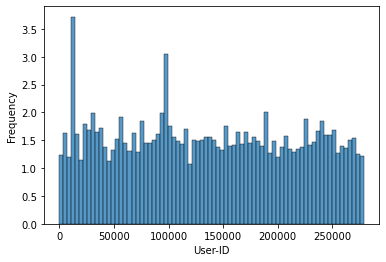

In [123]:
# EDA what now?
import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

sn.histplot(data=ratings, x="User-ID", stat='frequency')
plt.show()

This graph gives an idea of the average number of ratings per user, but it's misleading because it doesn't show that over half the users have no ratings.

In [125]:
print('Number of users with reviews: ', len(pd.unique(ratings['User-ID'])), 'out of', len(users), 'users')
print('Number of books reviewed: ', len(pd.unique(ratings['ISBN'])), 'out of', len(books), 'books')
print("Before I dropped the implicit ratings there were more isbns in the ratings than in the list of books. Probably the list of books isn't completely exhaustive.")

Number of users with reviews:  77806 out of 278859 users
Number of books reviewed:  185842 out of 270968 books
Before I dropped the implicit ratings there were more isbns in the ratings than in the list of books. Probably the list of books isn't completely exhaustive.


Below I create a dataframe with rating counts and means to make a simple book recommender.

In [47]:
mean_ratings = ratings.groupby(['ISBN'], sort=False, as_index=False).mean()

In [48]:
rating_counts = ratings.groupby(['ISBN'], sort=False, as_index=False).count()

In [49]:
books_with_ratings = mean_ratings.merge(rating_counts, on='ISBN', suffixes=('-Mean', '-Count')).drop(['User-ID-Mean', 'User-ID-Count'], axis=1)

In [50]:
books_with_ratings.sort_values(by='Book-Rating-Mean', ascending=False)

,ISBN,Book-Rating-Mean,Book-Rating-Count
80630,0764224182,10.0,1
155233,2877142140,10.0,1
155170,8481301701,10.0,1
155174,8483009846,10.0,1
106970,0590633929,10.0,1
...,...,...,...
54753,8422693917,1.0,1
54752,8422693895,1.0,1
149579,0451456866,1.0,1
54746,8422693836,1.0,1


I'd like to list the most popular books, and since the highest rated ones all have just one rating, I'm going to set a limit of, let's say, 10 reveiews.

In [126]:
books_with_ratings[books_with_ratings['Book-Rating-Count']>50].sort_values(by='Book-Rating-Mean', ascending=False)

,ISBN,Book-Rating-Mean,Book-Rating-Count
21867,0345339738,9.402597,77
2542,0439139597,9.262774,137
10805,043936213X,9.236364,55
2852,0345339711,9.120482,83
1783,0439136369,9.082707,133
...,...,...,...
1489,0140244824,6.530303,66
5610,0451203895,5.653846,52
5140,080213825X,5.444444,54
1816,0425182908,5.338028,71


In [52]:
books.loc[books['ISBN'].str.contains('0345339738', case=False)] 

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
4206,0345339738,"The Return of the King (The Lord of the Rings,...",J.R.R. TOLKIEN,1986,Del Rey,http://images.amazon.com/images/P/0345339738.0...,http://images.amazon.com/images/P/0345339738.0...,http://images.amazon.com/images/P/0345339738.0...


At least it isn't Harry Potter

But not all the books in the data are for children! Look at this:

In [53]:
books.loc[books['Book-Author'].str.contains('Immanuel Kant', case=False)] 

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
74388,087220166X,Grounding for the Metaphysics of Morals: With ...,Immanuel Kant,1993,Hackett Publishing Company,http://images.amazon.com/images/P/087220166X.0...,http://images.amazon.com/images/P/087220166X.0...,http://images.amazon.com/images/P/087220166X.0...
152300,0375757333,Basic Writings of Kant (Modern Library Classics),IMMANUEL KANT,2001,Modern Library,http://images.amazon.com/images/P/0375757333.0...,http://images.amazon.com/images/P/0375757333.0...,http://images.amazon.com/images/P/0375757333.0...
154125,0521657296,Critique of Pure Reason,Immanuel Kant,1999,Cambridge University Press,http://images.amazon.com/images/P/0521657296.0...,http://images.amazon.com/images/P/0521657296.0...,http://images.amazon.com/images/P/0521657296.0...
175478,3895080756,Der Streit Der Facultaten Werke 6,Immanuel Kant,1999,Konemann Remainders,http://images.amazon.com/images/P/3895080756.0...,http://images.amazon.com/images/P/3895080756.0...,http://images.amazon.com/images/P/3895080756.0...
227507,0061311596,Groundwork of the Metaphysic of Morals,Immanuel Kant,1965,Perennial,http://images.amazon.com/images/P/0061311596.0...,http://images.amazon.com/images/P/0061311596.0...,http://images.amazon.com/images/P/0061311596.0...
238678,0879753773,Fundamental Principles of the Metaphysic of Mo...,Immanuel Kant,1987,Prometheus Books,http://images.amazon.com/images/P/0879753773.0...,http://images.amazon.com/images/P/0879753773.0...,http://images.amazon.com/images/P/0879753773.0...
238679,1573920630,Critique of Practical Reason (Great Books in P...,Immanuel Kant,1996,Prometheus Books,http://images.amazon.com/images/P/1573920630.0...,http://images.amazon.com/images/P/1573920630.0...,http://images.amazon.com/images/P/1573920630.0...
244458,0312450109,Immanuel Kant's Critique of Pure Reason,Immanuel Kant,1969,Bedford Books,http://images.amazon.com/images/P/0312450109.0...,http://images.amazon.com/images/P/0312450109.0...,http://images.amazon.com/images/P/0312450109.0...


I't not the Gesamtausgabe, but it gives me some hope.

In [56]:
get_book('0192126040')

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
271377,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...


### Simple recommender
It returns the n most popular books, but skips the ones you've already read.

In [57]:
def recommend_books(books_read, titles=books, reviews=books_with_ratings, mode='popularity', n=10, min_ratings=50):
    titles_list = pd.DataFrame()
    #reviews_list = pd.DataFrame()
    popular = reviews[reviews['Book-Rating-Count']>min_ratings].sort_values(by='Book-Rating-Mean', ascending=False)
    i = 0
    while len(titles_list.index) < n:
        # get most popular isbns
        review = popular.iloc[i]
        isbn = review['ISBN']
        #print(titles_list)
        if not books_read['ISBN'].str.contains(isbn).any():
            title = get_book(isbn)
            titles_list = pd.concat([title, titles_list])
            #reviews_list = pd.concat([review, reviews_list])
        i+=1
    
    #return_df = titles_df.merge(reviews_df, on='ISBN', axis=1)
    return titles_list

I'm testing it on a hypothetical reader who's read everything by Kant but nothing else.

In [127]:
Kant = books.loc[books['Book-Author'].str.contains('Immanuel Kant', case=False)] 
recommend_books(Kant)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
388,0156528207,The Little Prince,Antoine de Saint-ExupÃÂ©ry,1968,Harcourt,http://images.amazon.com/images/P/0156528207.0...,http://images.amazon.com/images/P/0156528207.0...,http://images.amazon.com/images/P/0156528207.0...
2809,0590353403,Harry Potter and the Sorcerer's Stone (Book 1),J. K. Rowling,1998,Scholastic,http://images.amazon.com/images/P/0590353403.0...,http://images.amazon.com/images/P/0590353403.0...,http://images.amazon.com/images/P/0590353403.0...
3839,0439136350,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,1999,Scholastic,http://images.amazon.com/images/P/0439136350.0...,http://images.amazon.com/images/P/0439136350.0...,http://images.amazon.com/images/P/0439136350.0...
5506,043935806X,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,2003,Scholastic,http://images.amazon.com/images/P/043935806X.0...,http://images.amazon.com/images/P/043935806X.0...,http://images.amazon.com/images/P/043935806X.0...
3847,0064400557,Charlotte's Web (Trophy Newbery),E. B. White,1974,HarperTrophy,http://images.amazon.com/images/P/0064400557.0...,http://images.amazon.com/images/P/0064400557.0...,http://images.amazon.com/images/P/0064400557.0...
6330,0439136369,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,2001,Scholastic,http://images.amazon.com/images/P/0439136369.0...,http://images.amazon.com/images/P/0439136369.0...,http://images.amazon.com/images/P/0439136369.0...
780,0345339711,"The Two Towers (The Lord of the Rings, Part 2)",J.R.R. TOLKIEN,1986,Del Rey,http://images.amazon.com/images/P/0345339711.0...,http://images.amazon.com/images/P/0345339711.0...,http://images.amazon.com/images/P/0345339711.0...
9027,043936213X,Harry Potter and the Sorcerer's Stone (Book 1),J. K. Rowling,2001,Scholastic,http://images.amazon.com/images/P/043936213X.0...,http://images.amazon.com/images/P/043936213X.0...,http://images.amazon.com/images/P/043936213X.0...
5431,0439139597,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,2000,Scholastic,http://images.amazon.com/images/P/0439139597.0...,http://images.amazon.com/images/P/0439139597.0...,http://images.amazon.com/images/P/0439139597.0...
4206,0345339738,"The Return of the King (The Lord of the Rings,...",J.R.R. TOLKIEN,1986,Del Rey,http://images.amazon.com/images/P/0345339738.0...,http://images.amazon.com/images/P/0345339738.0...,http://images.amazon.com/images/P/0345339738.0...


At this point I got frustrated at all the children's books and tried to make a simple recommender for adults. I had to raise the age of majority to 35, but it did help a little.

In [60]:
of_age_users = users[users['Age']>35]
of_age_users = of_age_users[of_age_users['User-ID'].isin(ratings['User-ID'])]

In [63]:
adult_means = ratings[ratings['User-ID'].isin(of_age_users['User-ID'])].groupby(['ISBN'], sort=False, as_index=False).mean()
adult_ratings = ratings[ratings['User-ID'].isin(of_age_users['User-ID'])].groupby(['ISBN'], sort=False, as_index=False).count()
rated_by_adults = adult_means.merge(adult_ratings, on='ISBN', suffixes=('-Mean', '-Count')).drop(['User-ID-Mean', 'User-ID-Count'], axis=1)

In [64]:
recommend_books(Kant,reviews=rated_by_adults)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
522,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...,http://images.amazon.com/images/P/0312195516.0...
118,0671027360,Angels & Demons,Dan Brown,2001,Pocket Star,http://images.amazon.com/images/P/0671027360.0...,http://images.amazon.com/images/P/0671027360.0...,http://images.amazon.com/images/P/0671027360.0...
1922,067976402X,Snow Falling on Cedars,David Guterson,1995,Vintage Books USA,http://images.amazon.com/images/P/067976402X.0...,http://images.amazon.com/images/P/067976402X.0...,http://images.amazon.com/images/P/067976402X.0...
1373,0060930535,The Poisonwood Bible: A Novel,Barbara Kingsolver,1999,Perennial,http://images.amazon.com/images/P/0060930535.0...,http://images.amazon.com/images/P/0060930535.0...,http://images.amazon.com/images/P/0060930535.0...
748,0385504209,The Da Vinci Code,Dan Brown,2003,Doubleday,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...,http://images.amazon.com/images/P/0385504209.0...
38,0449005615,Seabiscuit: An American Legend,LAURA HILLENBRAND,2002,Ballantine Books,http://images.amazon.com/images/P/0449005615.0...,http://images.amazon.com/images/P/0449005615.0...,http://images.amazon.com/images/P/0449005615.0...
2290,0385484518,"Tuesdays with Morrie: An Old Man, a Young Man,...",MITCH ALBOM,1997,Doubleday,http://images.amazon.com/images/P/0385484518.0...,http://images.amazon.com/images/P/0385484518.0...,http://images.amazon.com/images/P/0385484518.0...
356,0142001740,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books,http://images.amazon.com/images/P/0142001740.0...,http://images.amazon.com/images/P/0142001740.0...,http://images.amazon.com/images/P/0142001740.0...
2143,059035342X,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,1999,Arthur A. Levine Books,http://images.amazon.com/images/P/059035342X.0...,http://images.amazon.com/images/P/059035342X.0...,http://images.amazon.com/images/P/059035342X.0...
5506,043935806X,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,2003,Scholastic,http://images.amazon.com/images/P/043935806X.0...,http://images.amazon.com/images/P/043935806X.0...,http://images.amazon.com/images/P/043935806X.0...


Still a lot of Harry Potter here, but it's been pushed down the list a litte.

A nice feature of this recommender is that it's simple enough to be applied recirsively:

In [65]:
recommend_books(recommend_books(Kant,reviews=rated_by_adults), reviews=rated_by_adults)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
1496,0743418174,Good in Bed,Jennifer Weiner,2002,Washington Square Press,http://images.amazon.com/images/P/0743418174.0...,http://images.amazon.com/images/P/0743418174.0...,http://images.amazon.com/images/P/0743418174.0...
1485,0060934417,Bel Canto: A Novel,Ann Patchett,2002,Perennial,http://images.amazon.com/images/P/0060934417.0...,http://images.amazon.com/images/P/0060934417.0...,http://images.amazon.com/images/P/0060934417.0...
563,0156027321,Life of Pi,Yann Martel,2003,Harvest Books,http://images.amazon.com/images/P/0156027321.0...,http://images.amazon.com/images/P/0156027321.0...,http://images.amazon.com/images/P/0156027321.0...
134,0060976845,Little Altars Everywhere: A Novel,Rebecca Wells,1996,Perennial,http://images.amazon.com/images/P/0060976845.0...,http://images.amazon.com/images/P/0060976845.0...,http://images.amazon.com/images/P/0060976845.0...
1105,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial,http://images.amazon.com/images/P/0060928336.0...,http://images.amazon.com/images/P/0060928336.0...,http://images.amazon.com/images/P/0060928336.0...
1406,1400034779,The No. 1 Ladies' Detective Agency (Today Show...,Alexander McCall Smith,2003,Anchor,http://images.amazon.com/images/P/1400034779.0...,http://images.amazon.com/images/P/1400034779.0...,http://images.amazon.com/images/P/1400034779.0...
706,0446672211,Where the Heart Is (Oprah's Book Club (Paperba...,Billie Letts,1998,Warner Books,http://images.amazon.com/images/P/0446672211.0...,http://images.amazon.com/images/P/0446672211.0...,http://images.amazon.com/images/P/0446672211.0...
231,0452282152,Girl with a Pearl Earring,Tracy Chevalier,2001,Plume Books,http://images.amazon.com/images/P/0452282152.0...,http://images.amazon.com/images/P/0452282152.0...,http://images.amazon.com/images/P/0452282152.0...
2802,0060392452,Stupid White Men ...and Other Sorry Excuses fo...,Michael Moore,2002,Regan Books,http://images.amazon.com/images/P/0060392452.0...,http://images.amazon.com/images/P/0060392452.0...,http://images.amazon.com/images/P/0060392452.0...
408,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown",http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...,http://images.amazon.com/images/P/0316666343.0...


### Collaborative filtering
To make collaborative filtering work, I had to pare down the data a little. For a while I had a problem where my own ratings were disappearing, but I eventually figured out that the isbns had gotten reinterpreted as numbers at some point.

In [66]:
reduced_users = ratings['User-ID'].value_counts()
reduced_users_list = reduced_users[reduced_users >= 3].index.to_list()

reduced_ratings = ratings[ratings['User-ID'].isin(reduced_users_list)]

In [69]:
most_rated_isbns = books_with_ratings[books_with_ratings['Book-Rating-Count']>15]['ISBN']

In [70]:
reduced_ratings = reduced_ratings[reduced_ratings['ISBN'].isin(most_rated_isbns)]

In [73]:
reduced_ratings[reduced_ratings['User-ID'] == 278859]

,User-ID,ISBN,Book-Rating
1149782,278859,0553262505,9
1149785,278859,0345325818,6
1149787,278859,0553212583,10
1149789,278859,0451169530,6
1149790,278859,0671041789,4
1149791,278859,0553213695,8
1149794,278859,0553560735,7
1149796,278859,0345339681,8
1149797,278859,0441569595,4


In [74]:
#This repo helped me a lot
#https://github.com/tttgm/fellowshipai/blob/master/Book-Crossing-Recommender.ipynb
#Build the ratings matrix using pivot_table function
r_matrix = reduced_ratings.pivot_table(values='Book-Rating', index='User-ID', columns='ISBN')

r_matrix.head()

ISBN,000649840X,0007110928,0020198906,0020199600,0020442203,002542730X,0028604199,0028604202,006000438X,0060008024,...,8495618605,8804342838,8806142100,8806143042,880781210X,8807813025,8817106100,8845205118,884590184X,8873122933
User-ID,,,,,,,,,,,,,,,,,,,,,
17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
r_matrix.shape

(16379, 2928)

In [76]:
#Create a dummy ratings matrix with all null values imputed to 0
r_matrix_dummy = r_matrix.copy().fillna(0)

In [77]:
# Import cosine_score 
from sklearn.metrics.pairwise import cosine_similarity

#Compute the cosine similarity matrix using the dummy ratings matrix
cosine_sim = cosine_similarity(r_matrix_dummy, r_matrix_dummy)

In [78]:
#Convert into pandas dataframe 
cosine_sim = pd.DataFrame(cosine_sim, index=r_matrix.index, columns=r_matrix.index)

cosine_sim.head(10)

User-ID,17,69,99,114,165,232,242,243,244,254,...,278633,278663,278694,278773,278832,278843,278844,278851,278854,278859
User-ID,,,,,,,,,,,,,,,,,,,,,
17,1.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
69,0.0,1.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
99,0.0,0.0,1.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
114,0.0,0.0,0.0,1.000000,0.201946,0.0,0.0,0.000000,0.000000,0.0,...,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
165,0.0,0.0,0.0,0.201946,1.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
232,0.0,0.0,0.0,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.0,...,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
242,0.0,0.0,0.0,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0,...,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0
243,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,1.000000,0.131286,0.0,...,0.04465,0.0,0.0,0.0,0.097257,0.000000,0.000000,0.0,0.0,0.0
244,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.131286,1.000000,0.0,...,0.00000,0.0,0.0,0.0,0.170872,0.000000,0.000000,0.0,0.0,0.0


In [151]:
#User Based Collaborative Filter using Weighted Mean Ratings
def cf_user_wmean(user_id, book_id):
    
    #Check if movie_id exists in r_matrix
    if book_id in r_matrix:
        
        #Get the similarity scores for the user in question with every other user
        sim_scores = cosine_sim[user_id]
        
        #Get the user ratings for the book in question
        b_ratings = r_matrix[book_id]
        
        #Extract the indices containing NaN in the b_ratings series
        idx = b_ratings[b_ratings.isnull()].index
        idx.append(b_ratings[b_ratings < 0.001].index)
        #Drop the NaN values from the b_ratings Series
        b_ratings = b_ratings[b_ratings >= 0.001]
        
        #Drop the corresponding cosine scores from the sim_scores series
        sim_scores = sim_scores.drop(idx)
        
        #Compute the final weighted mean
        wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
    
    else:
        #Default to a rating of 5.0 in the absence of any information
        wmean_rating = 5.0
    
    return wmean_rating

Now I want to try it myself! Let's dig up my user id.

In [152]:
Kraakan

278859

In [153]:
cf_user_wmean(Kraakan,'0671027360')

8.35604005099308

In [84]:
get_book('0671027360')

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
118,0671027360,Angels & Demons,Dan Brown,2001,Pocket Star,http://images.amazon.com/images/P/0671027360.0...,http://images.amazon.com/images/P/0671027360.0...,http://images.amazon.com/images/P/0671027360.0...


Angels & Demons rated higher than I would have expected, but let's see if I can find my highest rated books.

In [157]:
Kraakans_books_list = [] #pd.DataFrame({'isbn': [], 'score': []})
for isbn in reduced_ratings['ISBN']:
    score = cf_user_wmean(Kraakan, isbn)
    new_row = pd.Series({'isbn': isbn, 'score': score})
    #pd.concat([Kraakans_books, new_row.to_frame().T], ignore_index=True)
    Kraakans_books_list.append(new_row)
Kraakans_books = pd.DataFrame(Kraakans_books_list)

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/3935829553.py:23: RuntimeWarning: invalid value encountered in double_scalars
  wmean_rating = np.dot(sim_scores, b_ratings)/ sim_scores.sum()
/tmp/ipykernel_4248/39

This code took a few moments to run, and there are a lot of warnings because of division with very small numbers. Let's see what we got!

In [161]:
Kraakans_books.sort_values(by=['score'], ascending=False).head(10)

,isbn,score
81385,0553351397,10.0
55216,0156012197,10.0
51493,0310205719,10.0
12113,0553274325,10.0
47378,0552134627,10.0
12361,0552134627,10.0
27495,0552134627,10.0
20425,0310205719,10.0
87841,0552134627,10.0
8043,0553274325,10.0


In [172]:
for isbn in Kraakans_books.sort_values(by=['score'], ascending=False).head(20)['isbn']:
    book = get_book(isbn)
    if not book.empty: print(book['ISBN'].iloc[0], book['Book-Title'].iloc[0], 'by', book['Book-Author'].iloc[0])

0553351397 Peace Is Every Step: The Path of Mindfulness in Everyday Life by Thich Nhat Hahn
0156012197 The Little Prince by Antoine de Saint-ExupÃÂ©ry
0310205719 The Purpose-Driven Life: What on Earth Am I Here For? by Rick Warren
0553274325 Johnny Got His Gun by Dalton Trumbo
0310205719 The Purpose-Driven Life: What on Earth Am I Here For? by Rick Warren
0553274325 Johnny Got His Gun by Dalton Trumbo
0156012197 The Little Prince by Antoine de Saint-ExupÃÂ©ry
0451197399 The Ballad of Frankie Silver by Sharyn McCrumb
0310205719 The Purpose-Driven Life: What on Earth Am I Here For? by Rick Warren
0451197399 The Ballad of Frankie Silver by Sharyn McCrumb
0553287737 The Bourne Ultimatum by Robert Ludlum
0316693006 Four Blind Mice by James Patterson
0553212621 Lady Chatterley's Lover: Complete and Unexpurgated 1928 Orioli Edition by D. H. Lawrence


It's a little annoiung that the same isbns appear several times, but I could see myself reading two of the novels on the list, so I'll call it a success! I seem to have gotten a few hits for philosophy as well, but they're not the kinds of books I tend to read.

### SVD-model based filtering

In [85]:
reader = surprise.Reader(rating_scale=(1, 10))
data = surprise.Dataset.load_from_df(reduced_ratings, reader)

In [86]:
# Load SVD algorithm
model = surprise.SVD()

# Train on books dataset
%time surprise.model_selection.cross_validate(model, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.5919  1.6042  1.6022  1.5967  1.6113  1.6013  0.0066  
Fit time          0.89    0.89    0.94    0.90    0.92    0.91    0.02    
Test time         0.17    0.16    0.16    0.18    0.18    0.17    0.01    
CPU times: user 6.44 s, sys: 16.1 ms, total: 6.45 s
Wall time: 6.46 s


{'test_rmse': array([1.59193723, 1.60423036, 1.60218464, 1.59666135, 1.61126435]),
 'fit_time': (0.8946325778961182,
  0.8854718208312988,
  0.9376325607299805,
  0.8960621356964111,
  0.9181573390960693),
 'test_time': (0.16692781448364258,
  0.15899157524108887,
  0.15950751304626465,
  0.17711472511291504,
  0.17913055419921875)}

In [87]:
# set test set to 20%.
trainset, testset = surprise.model_selection.train_test_split(data, test_size=0.2)

# Instantiate the SVD model.
model = surprise.SVD()

# Train the algorithm on the training set, and predict ratings for the test set
model.fit(trainset)
predictions = model.test(testset)

# Then compute RMSE
surprise.accuracy.rmse(predictions)

RMSE: 1.6070


1.6069823619662789

In [88]:
from collections import defaultdict

def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
        
    return top_n

In [89]:
def get_reading_list(userid):
    pd.set_option('mode.chained_assignment',None)
    reading_list = pd.DataFrame()
    top_n = get_top_n(predictions, n=10)
    for n in top_n[userid]:
        isbn, rating = n
        book = books.loc[books['ISBN']==isbn]
        book['rating'] = rating
        reading_list = pd.concat([book, reading_list])
    return reading_list

In [90]:
get_reading_list(Kraakan)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,rating
993,0553212583,Wuthering Heights,EMILY BRONTE,1983,Bantam,http://images.amazon.com/images/P/0553212583.0...,http://images.amazon.com/images/P/0553212583.0...,http://images.amazon.com/images/P/0553212583.0...,7.12889


In [108]:
users[users['User-ID']==Kraakan]

,User-ID,Location,Age
278858,278859,"Helsinki, Finland",37.0


The only recommendation for me is a book I already read! This user from the dataset did better though. I think it's because they had a frankly unrealistic amount of ratings.

In [113]:
test = get_top_n(predictions, n=10)[11676]

In [120]:
for isbn, score in test:
    #print(isbn, score)
    result = books.loc[books['ISBN']==isbn].iloc[0]
    print(result['Book-Title'], 'by', result['Book-Author'], '- score:', score)

The Firm by John Grisham - score: 9.974797961572223
Harry Potter and the Goblet of Fire (Book 4) by J. K. Rowling - score: 9.867901371356963
Preludes and Nocturnes (Sandman, Book 1) by Neil Gaiman - score: 9.657909112087541
The Five People You Meet in Heaven by Mitch Albom - score: 9.377795231173657
Interview with the Vampire by Anne Rice - score: 9.360459472231488
Midnight Bayou by Nora Roberts - score: 9.328922156547945
Out to Canaan (The Mitford Years) by Jan Karon - score: 9.228402345391547
Jurassic Park by Michael Crichton - score: 9.164829385314622
Bare Bones : A Novel by Kathy Reichs - score: 9.137729283088492
The Dilbert Principle: A Cubicle'S-Eye View of Bosses, Meetings, Management Fads & Other Workplace Afflictions by Scott Adams - score: 9.119896194482122
